In [1]:
import gurobipy as gp
from gurobipy import GRB

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_excel('TR81_KGM.xls')
df = df.fillna(99999) # since Gurobi doesn't allow for infinity as distance, we put a very large number (M)
df.drop(["İL NO", "İL ADI", "İL ADI.1", "İL NO.1"], axis=1, inplace=True)
df

,ADANA,ADIYAMAN,AFYON,AĞRI,AMASYA,ANKARA,ANTALYA,ARTVİN,AYDIN,BALIKESİR,...,BATMAN,ŞIRNAK,BARTIN,ARDAHAN,IĞDIR,YALOVA,KARABÜK,KİLİS,OSMANİYE,DÜZCE
0,99999.000000,333.000000,573.000000,965.000000,611.00000,490.00000,558.00000,1034.000000,883.000000,897.000000,...,618.000000,717.000000,769.000000,1038.000000,1068.000000,893.000000,701.00000,246.000000,87.000000,722.000000
1,333.000000,99999.000000,906.000000,648.000000,634.00000,755.00000,891.00000,755.000000,1216.000000,1230.000000,...,301.000000,480.000000,1038.000000,759.000000,751.000000,1162.000000,970.00000,209.000000,246.000000,991.000000
2,573.000000,906.000000,99999.000000,1311.000000,590.00000,256.00000,292.00000,1237.000000,346.000000,324.000000,...,1191.000000,1290.000000,515.000000,1346.000000,1421.000000,341.000000,447.00000,819.000000,660.000000,375.000000
3,965.000000,648.000000,1311.000000,99999.000000,738.00000,1055.00000,1432.00000,397.000000,1645.000000,1571.000000,...,369.000000,426.000000,1173.000000,310.000000,143.000000,1363.000000,1104.00000,815.000000,878.000000,1192.000000
4,611.000000,634.000000,590.000000,738.000000,99999.00000,334.00000,826.00000,695.000000,932.000000,833.000000,...,800.000000,982.000000,435.000000,779.000000,848.000000,625.000000,366.00000,666.000000,629.000000,454.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,246.000000,209.000000,819.000000,815.000000,666.00000,730.00000,804.00000,922.000000,1129.000000,1143.000000,...,468.000000,567.000000,1013.000000,926.000000,918.000000,1137.000000,945.00000,99999.000000,159.000000,966.000000
79,87.000000,246.000000,660.000000,878.000000,629.00000,577.00000,645.00000,947.000000,970.000000,984.000000,...,531.000000,630.000000,856.000000,951.000000,981.000000,980.000000,788.00000,159.000000,99999.000000,809.000000
80,722.000000,991.000000,375.000000,1192.000000,454.00000,236.00000,639.00000,1084.000000,673.000000,379.000000,...,1246.000000,1415.000000,203.000000,1193.000000,1302.000000,171.000000,179.00000,966.000000,809.000000,99999.000000
81,37.000000,37.764751,38.750714,39.626922,40.64991,39.92077,36.88414,41.182770,37.856041,39.648369,...,37.881168,37.418748,41.581051,41.110481,39.887984,40.650000,41.20610,36.718399,37.213026,40.843849


In [4]:
city_indexes = list(range(81)) # getting [0, 1, ..., 80] for indexation purposes
u = list(range(1, 81)) # getting [1, 2, ..., 80] for Miller-Tucker-Zemlin constraint indexation purposes
cost_matrix = df.iloc[city_indexes, city_indexes] # Extracting distances between cities
cities_list = list(cost_matrix.columns.values) # Extracting names of cities from data frame
cost_matrix = cost_matrix.values.tolist() # Converting data frame for distances into python list (represented as matrix)


In [5]:
tsp = gp.Model() # Initialization of the Gurobi model

X = {}
U = {}

# X_ij is a binary variable => 1 if the salesperson visits city j directly after city i, 0 otherwise
for i in city_indexes:
    for j in city_indexes:
        X[i, j] = tsp.addVar(vtype=GRB.BINARY)

# U_i is a integer variable => indicate the sequence in which city i is visited (for the first city, it is not defined)
for i in city_indexes:
    U[i] = tsp.addVar(vtype=GRB.CONTINUOUS)

# Objective function
tsp.setObjective(gp.quicksum(cost_matrix[i][j]*X[i, j] for i in city_indexes for j in city_indexes), GRB.MINIMIZE)

# Assignment constraints
for i in city_indexes:
    tsp.addConstr(gp.quicksum(X[i, j] for j in city_indexes if i != j) == 1)
    tsp.addConstr(gp.quicksum(X[j, i] for j in city_indexes if i != j) == 1)

# For the first city, U variable is not significant
tsp.addConstr(U[0] == 0)

# Upper and lower bounds for U variables
for i in u:
    tsp.addConstr(U[i] >= 1)
    tsp.addConstr(U[i] <= 81)

# Subtour elimination constraints
for i in u:
    for j in u:
        if i != j:
            tsp.addConstr(U[i] - U[j] + 81*X[i, j] <= 80)

tsp.setParam('TimeLimit', 60)  # Set a time limit of 60 seconds
tsp.setParam('MIPGap', 0.01)  # Set the MIPGap parameter to 1%
tsp.optimize()



Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-05
Set parameter TimeLimit to value 60
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 6643 rows, 6642 columns and 32081 nonzeros
Model fingerprint: 0xdd92b21c
Variable types: 81 continuous, 6561 integer (6561 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [4e+01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+01]
Presolve removed 161 rows and 82 columns
Presolve time: 0.07s
Presolved: 6482 rows, 6560 columns, 31920 nonzeros
Variable types: 80 continuous, 6480 integer (6480 binary)

Root relaxation: objective 8.552568e+03, 315 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Ob

In [6]:
# By the help of this code block, we extracted which binary variables are 1
# i.e. which cities are visited directly from where
from_to_list = list()
for i in city_indexes:
    for j in city_indexes:
        if X[i, j].x > 0.5:
            from_to_list.append((i, j))
            
# In order to construct the optimal route, we need to find the whole sequence
# which starts from Adana (also ends at Adana) and traverses whole Turkey. The above "from_to_list" stores the
# needed information unordered. So, we sorted the "from_to_list" into "ordered_from_to_list"
index_of_starting_city = 0
ordered_from_to_list = list()
while True:
    found = False
    for i, j in from_to_list:
        if i == index_of_starting_city:
            ordered_from_to_list.append((i, j))
            index_of_starting_city = j
            from_to_list.remove((i, j))
            found = True
            break

    if not found:
        break
        
route = list()
for i, j in ordered_from_to_list:
    route.append(cities_list[i])
    route.append(cities_list[j])

print("Total optimal distance for 81 cities is " + str(tsp.objVal) + " kms.")
print("The optimal route is " + str(route))

Total optimal distance for 81 cities is 9938.0 kms.
The optimal route is ['ADANA', 'İÇEL', 'İÇEL', 'KARAMAN', 'KARAMAN', 'KONYA', 'KONYA', 'AKSARAY', 'AKSARAY', 'NEVŞEHİR', 'NEVŞEHİR', 'NİĞDE', 'NİĞDE', 'KAYSERİ', 'KAYSERİ', 'SİVAS', 'SİVAS', 'TOKAT', 'TOKAT', 'AMASYA', 'AMASYA', 'ÇORUM', 'ÇORUM', 'YOZGAT', 'YOZGAT', 'KIRŞEHİR', 'KIRŞEHİR', 'KIRIKKALE', 'KIRIKKALE', 'ÇANKIRI', 'ÇANKIRI', 'ANKARA', 'ANKARA', 'ESKİŞEHİR', 'ESKİŞEHİR', 'KÜTAHYA', 'KÜTAHYA', 'AFYON', 'AFYON', 'UŞAK', 'UŞAK', 'ISPARTA', 'ISPARTA', 'BURDUR', 'BURDUR', 'ANTALYA', 'ANTALYA', 'DENİZLİ', 'DENİZLİ', 'MUĞLA', 'MUĞLA', 'AYDIN', 'AYDIN', 'İZMİR', 'İZMİR', 'MANİSA', 'MANİSA', 'BALIKESİR', 'BALIKESİR', 'ÇANAKKALE', 'ÇANAKKALE', 'EDİRNE', 'EDİRNE', 'KIRKLARELİ', 'KIRKLARELİ', 'TEKİRDAĞ', 'TEKİRDAĞ', 'İSTANBUL', 'İSTANBUL', 'KOCAELİ', 'KOCAELİ', 'YALOVA', 'YALOVA', 'BURSA', 'BURSA', 'BİLECİK', 'BİLECİK', 'SAKARYA', 'SAKARYA', 'DÜZCE', 'DÜZCE', 'BOLU', 'BOLU', 'ZONGULDAK', 'ZONGULDAK', 'BARTIN', 'BARTIN', 'KARABÜK', 'KAR

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

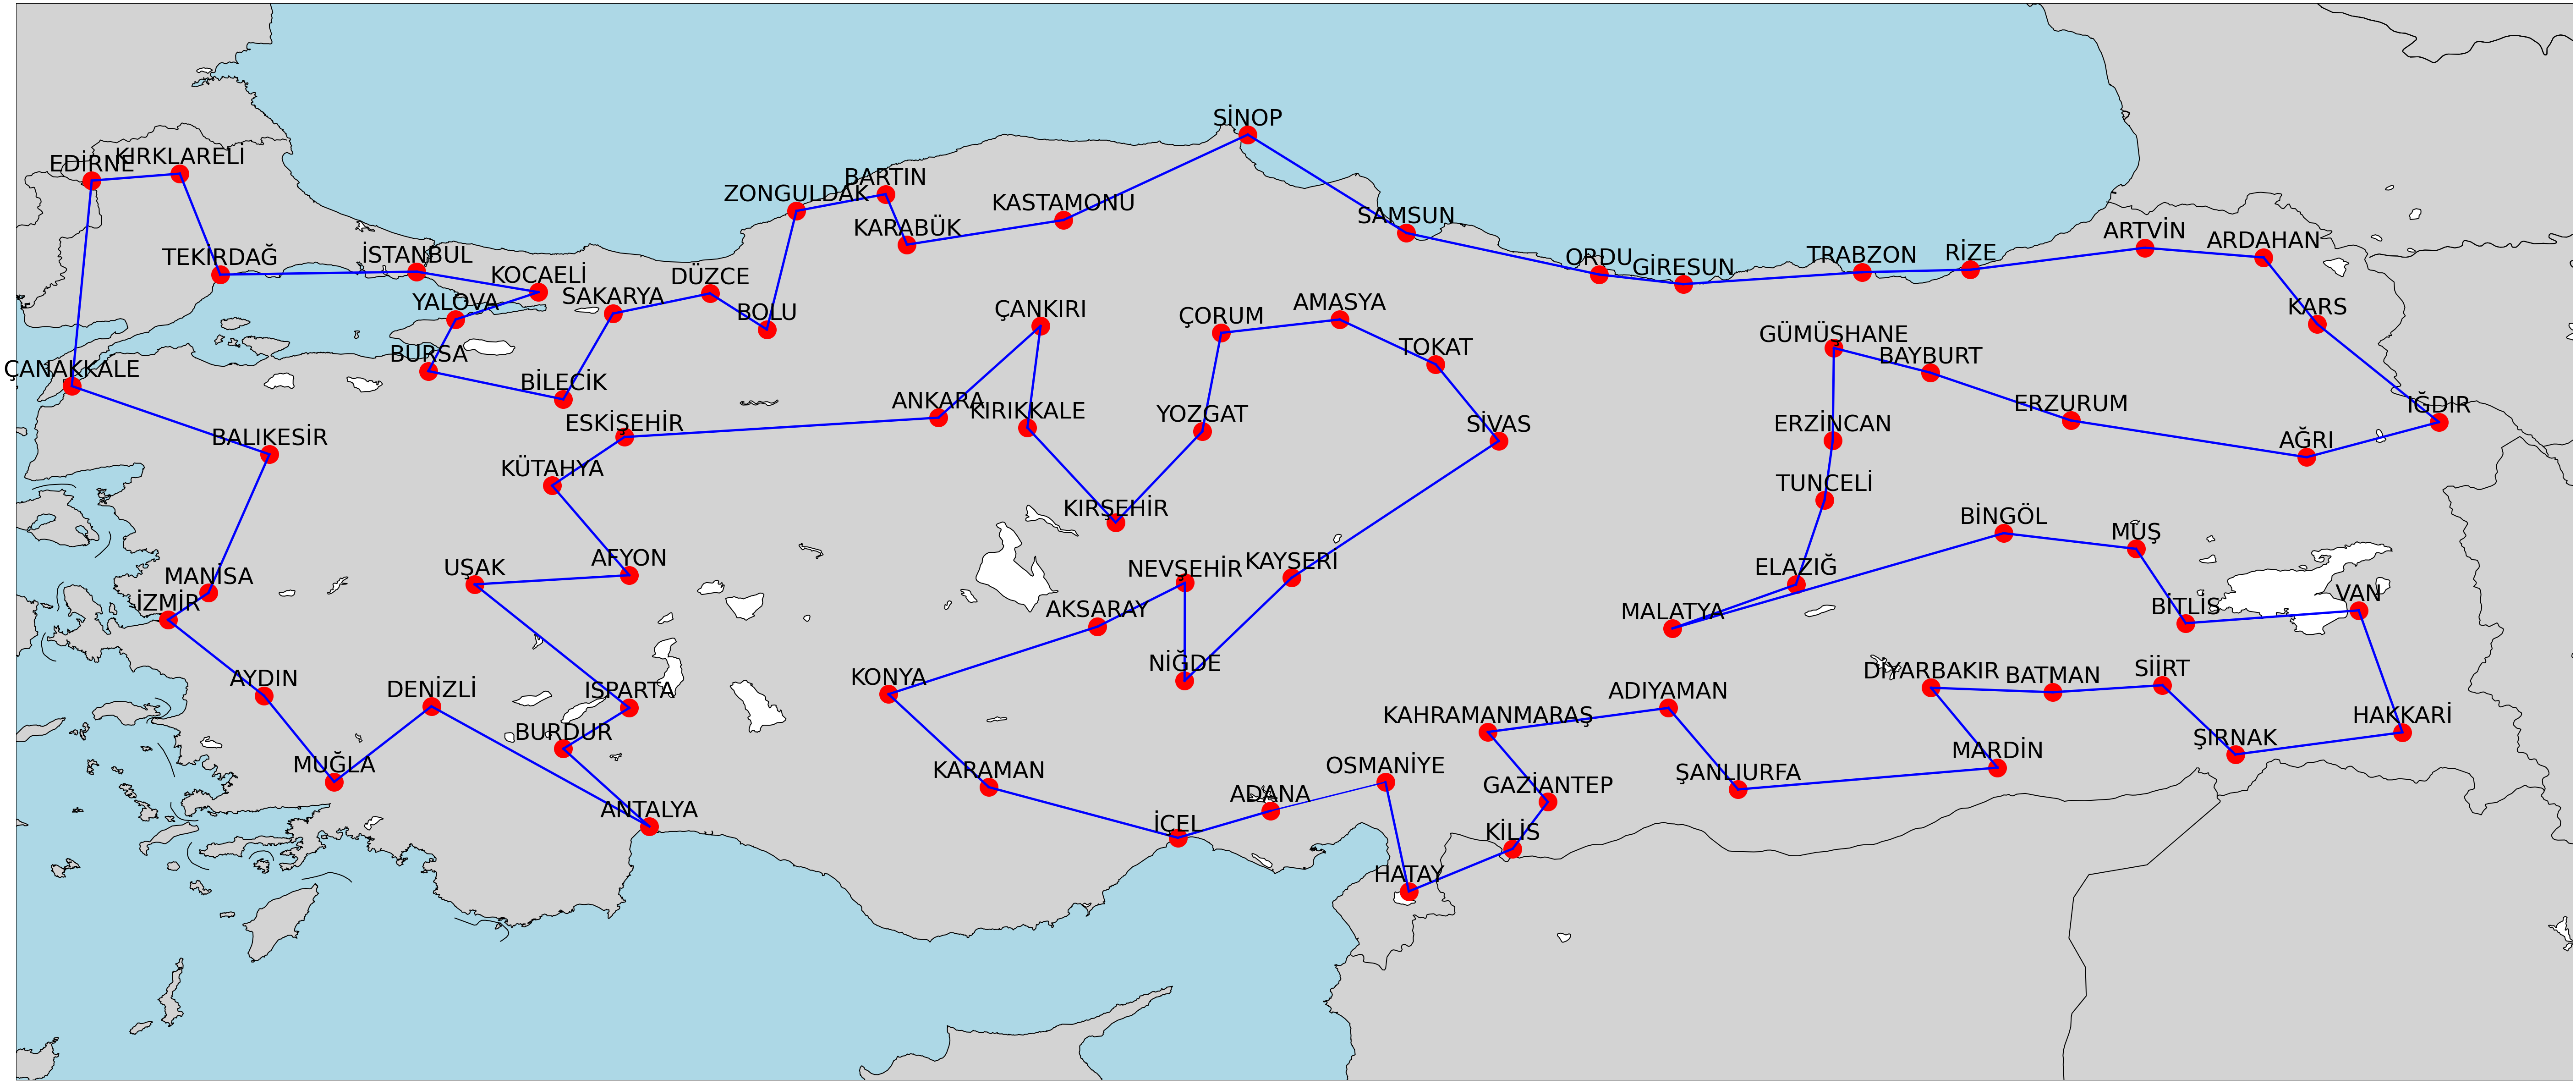

In [8]:
coordinates_dict = dict()
for city in route:
    if city in list(coordinates_dict.keys()):
        pass
    else:
        coordinates_dict[str(city)]=(df[str(city)][81],df[str(city)][82])

plt.figure(figsize=(100, 100))
map = Basemap(llcrnrlon=26, llcrnrlat=35, urcrnrlon=45, urcrnrlat=43, resolution='h')
map.drawcoastlines(linewidth=2.0)
map.drawcountries(linewidth=2.0)
map.fillcontinents(color='lightgray', lake_color='white', zorder=0)
map.drawmapboundary(fill_color='lightblue')

prev_x, prev_y = None, None
first_x, first_y = None, None
for city, coordinates in coordinates_dict.items():
    lat, lon = coordinates
    x, y = map(lon, lat)
    plt.plot(x, y, 'ro', markersize=40)  # Adjust markersize as desired
    plt.text(x, y + 0.2, city, fontsize=50, color='black', ha='center', va='top')

    if prev_x is not None and prev_y is not None:
        plt.plot([prev_x, x], [prev_y, y], 'b-', linewidth=5)  # Draw a blue line between consecutive cities

    if first_x is None and first_y is None:
        first_x, first_y = x, y

    prev_x, prev_y = x, y

# Connect the last city with the first city
if first_x is not None and first_y is not None:
    plt.plot([prev_x, first_x], [prev_y, first_y], 'b-', linewidth=3)

plt.show()